<a href="https://colab.research.google.com/github/Melsves/Klokkies2023/blob/master/Klokjes_statistieken.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from collections import defaultdict
from itertools import groupby, permutations

# Define a function to load JSON data from a file
def load_json_data(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Define a function to clean and prepare the data
def prepare_data(data):
    data['datetime'] = pd.to_datetime(data['data'] + ' ' + data['time'])
    data = data.drop(['data', 'time'], axis=1)
    data = data[data['official'] == 'true']
    data = data[~data['sender'].isin(['Debbie', 'Jarro'])]
    return data

# Define a function to plot cumulative counts
def plot_cumulative_counts(df, title, color_filter=None):
    plt.figure(figsize=(14, 7))
    if color_filter:
        df = df[df['color'].isin(color_filter)]
    final_counts = df.groupby('sender')['datetime'].max().sort_values(ascending=False)
    handles_labels = []
    for user in final_counts.index:
        user_data = df[df['sender'] == user]
        user_data = user_data.set_index('datetime').resample('D').size().cumsum().reset_index()
        if not user_data.empty:
            line, = plt.plot(user_data['datetime'], user_data[0], label=f"{user} ({user_data[0].iloc[-1]})")
            handles_labels.append(line)
    plt.legend(handles=handles_labels, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=int(len(handles_labels)/25)+1)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Number of Stickers')
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Define a function to calculate the longest streaks
def calculate_streaks(df):
    longest_streaks = {}
    for user, group in df.groupby('sender'):
        sorted_datetimes = group['datetime'].sort_values().tolist()
        streaks = []
        current_streak = [sorted_datetimes[0]]
        for current_datetime in sorted_datetimes[1:]:
            if (current_datetime - current_streak[-1]) <= timedelta(hours=6):
                current_streak.append(current_datetime)
            else:
                streaks.append(current_streak)
                current_streak = [current_datetime]
        streak_durations = [(streak[-1] - streak[0]).total_seconds() / 3600 for streak in streaks if len(streak) > 1]
        longest_streaks[user] = max(streak_durations) if streak_durations else 0
    return longest_streaks

# Define a function to find top color matches
def calculate_color_matches(df, window_minutes=60):
    color_matches = defaultdict(int)
    df_sorted = df.sort_values(by='datetime')
    for i, row in df_sorted.iterrows():
        window_start = row['datetime']
        window_end = window_start + timedelta(minutes=window_minutes)
        mask = (df_sorted['datetime'] >= window_start) & (df_sorted['datetime'] <= window_end)
        matches = df_sorted[mask]
        for _, match in matches.iterrows():
            if match['sender'] != row['sender']:
                color_matches[(row['sender'], match['sender'])] += 1
    return color_matches
# Define a function to plot the longest streaks
def plot_longest_streaks(df, title):
    longest_streaks = calculate_streaks(df)
    sorted_users = sorted(longest_streaks, key=longest_streaks.get, reverse=True)
    sorted_longest_streak_durations = [longest_streaks[user] for user in sorted_users]
    plt.figure(figsize=(12, 9))
    bars = plt.bar(sorted_users, sorted_longest_streak_durations)
    plt.xlabel('User')
    plt.ylabel('Longest Streak Duration (hours)')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Define a function to calculate sticker discos and the last user
def calculate_sticker_discos(df):
    disco_sequence = ['yellow', 'green', 'red', 'purple']
    disco_sequence_permutations = list(permutations(disco_sequence))
    df_sorted = df.sort_values(by='datetime')
    sticker_disco_count = 0
    last_sticker_user_count = defaultdict(int)
    for i in range(len(df_sorted) - 3):
        window = df_sorted.iloc[i:i+4]
        colors = window['color'].tolist()
        datetimes = window['datetime'].tolist()
        if tuple(colors) in disco_sequence_permutations:
            if all((datetimes[j+1] - datetimes[j] <= timedelta(hours=1)) for j in range(3)):
                sticker_disco_count += 1
                last_sticker_user_count[window.iloc[-1]['sender']] += 1
    sorted_last_sticker_users = sorted(last_sticker_user_count.items(), key=lambda x: x[1], reverse=True)
    return sticker_disco_count, sorted_last_sticker_users

# Define a function to plot patterns by day and hour
def plot_patterns(df, title_day, title_hour):
    df['day_of_week'] = df['datetime'].dt.day_name()
    df['hour_of_day'] = df['datetime'].dt.hour
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days, ordered=True)
    weekly_pattern = df.groupby('day_of_week').size()
    daily_pattern = df.groupby('hour_of_day').size()
    # Plot weekly pattern
    plt.figure(figsize=(10, 5))
    sns.barplot(x=weekly_pattern.index, y=weekly_pattern.values, palette="viridis")
    plt.title(title_day)
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Stickers')
    plt.xticks(rotation=45)
    plt.show()
    # Plot daily pattern
    plt.figure(figsize=(10, 5))
    sns.barplot(x=daily_pattern.index, y=daily_pattern.values, palette="viridis")
    plt.title(title_hour)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Stickers')
    plt.xticks(rotation=45)
    plt.show()

# Define a function to get color preferences
def get_color_preferences(df):
    user_color_preferences = df.groupby('sender')['color'].agg(lambda x: x.value_counts().index[0])
    overall_popular_color = df['color'].value_counts().idxmax()
    return user_color_preferences, overall_popular_color

# Define a function to plot cumulative counts with an optional year filter
def plot_cumulative_counts(df, title, color_filter=None, year_filter=None):
    plt.figure(figsize=(14, 7))
    if color_filter:
        df = df[df['color'].isin(color_filter)]
    if year_filter:
        df = df[df['datetime'].dt.year == year_filter]
    final_counts = df.groupby('sender')['datetime'].max().sort_values(ascending=False)
    handles_labels = []
    for user in final_counts.index:
        user_data = df[df['sender'] == user]
        user_data = user_data.set_index('datetime').resample('D').size().cumsum().reset_index()
        if not user_data.empty:
            line, = plt.plot(user_data['datetime'], user_data[0], label=f"{user} ({user_data[0].iloc[-1]})")
            handles_labels.append(line)
    plt.legend(handles=handles_labels, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=int(len(handles_labels)/25)+1)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Number of Stickers')
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
from datetime import timedelta
from collections import defaultdict

# Define the provided function to find top 3 matches of color values within an hour for each user
def calculate_color_matches(df):
    # Create a dictionary to store the matches
    color_matches = defaultdict(lambda: defaultdict(int))

    # Sort the dataframe by datetime
    df_sorted = df.sort_values(by='datetime')

    # Iterate over the rows of the dataframe
    for i, row in df_sorted.iterrows():
        sender = row['sender']
        color = row['color']
        datetime = row['datetime']

        # Find rows within an hour of the current row's datetime
        mask = (df_sorted['datetime'] >= datetime) & (df_sorted['datetime'] <= datetime + timedelta(minutes=5))
        matches = df_sorted[mask]

        # Update the color matches count for each user who sent the same color within the time frame
        for match_sender in matches['sender']:
            if match_sender != sender:
                color_matches[sender][match_sender] += 1

    # Sort the matches for each user and get the top 3
    top_matches = {user: sorted(matches.items(), key=lambda item: item[1], reverse=True)[:3]
                   for user, matches in color_matches.items()}
    return top_matches


from itertools import permutations

# Modify the function to check all permutations of the disco sequence colors
def count_sticker_discos_and_last_user(df):
    # Define the sequence of colors that make up a 'sticker disco'
    disco_sequence_permutations = list(permutations(['yellow', 'green', 'red', 'purple']))

    # Sort the dataframe by datetime to process the events in order
    df_sorted = df.sort_values(by='datetime')

    # Initialize the counter for 'sticker discos'
    sticker_disco_count = 0
    last_sticker_user_count = defaultdict(int)

    # Iterate through the DataFrame with a window of 4 entries
    for i in range(len(df_sorted) - 3):
        # Check all permutations for the next four entries
        window = df_sorted.iloc[i:i+4]
        colors = window['color'].tolist()
        datetimes = window['datetime'].tolist()

        # Check if the colors match any permutation of the disco sequence
        if tuple(colors) in disco_sequence_permutations:
            # Check the timestamps to ensure they are consecutive without long breaks
            if all((datetimes[j+1] - datetimes[j] <= pd.Timedelta(hours=1)) for j in range(3)):
                sticker_disco_count += 1
                # Get the user who sent the last sticker in the disco sequence
                last_sticker_user_count[window.iloc[-1]['sender']] += 1
                # Skip the next 3 entries to avoid counting overlapping 'sticker discos'
                i += 3

    # Sort the last sticker users by count
    sorted_last_sticker_users = sorted(last_sticker_user_count.items(), key=lambda x: x[1], reverse=True)

    return sticker_disco_count, sorted_last_sticker_users

def calculate_wcss(data):
    """
    Calculate the within-cluster sum of square for different number of clusters
    within the range of 1 to 10 (inclusive).
    """
    wcss = []
    for n in range(1, 11):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss


# Main execution
save_folder = '/content/drive/MyDrive/klokkies/'
file_path = '/content/drive/MyDrive/klokkies/Klokkendata.json'
data = pd.DataFrame(load_json_data(file_path))
# Prepare the data
data = prepare_data(data)




In [3]:

# Plot cumulative counts for red and purple stickers in 2023
plot_cumulative_counts(data, 'Cumulative Number of Official Red and Purple Stickers Sent (2023)', color_filter=['red', 'purple'], year_filter=2023)



,sender,color,official,datetime
15416,Djes,purple,true,2023-01-01 01:11:19
15417,Rogier,red,true,2023-01-01 01:22:50
15418,Manon,red,true,2023-01-01 01:34:28
15419,Mels,red,true,2023-01-01 01:37:23
15420,Luke,purple,true,2023-01-01 01:43:29


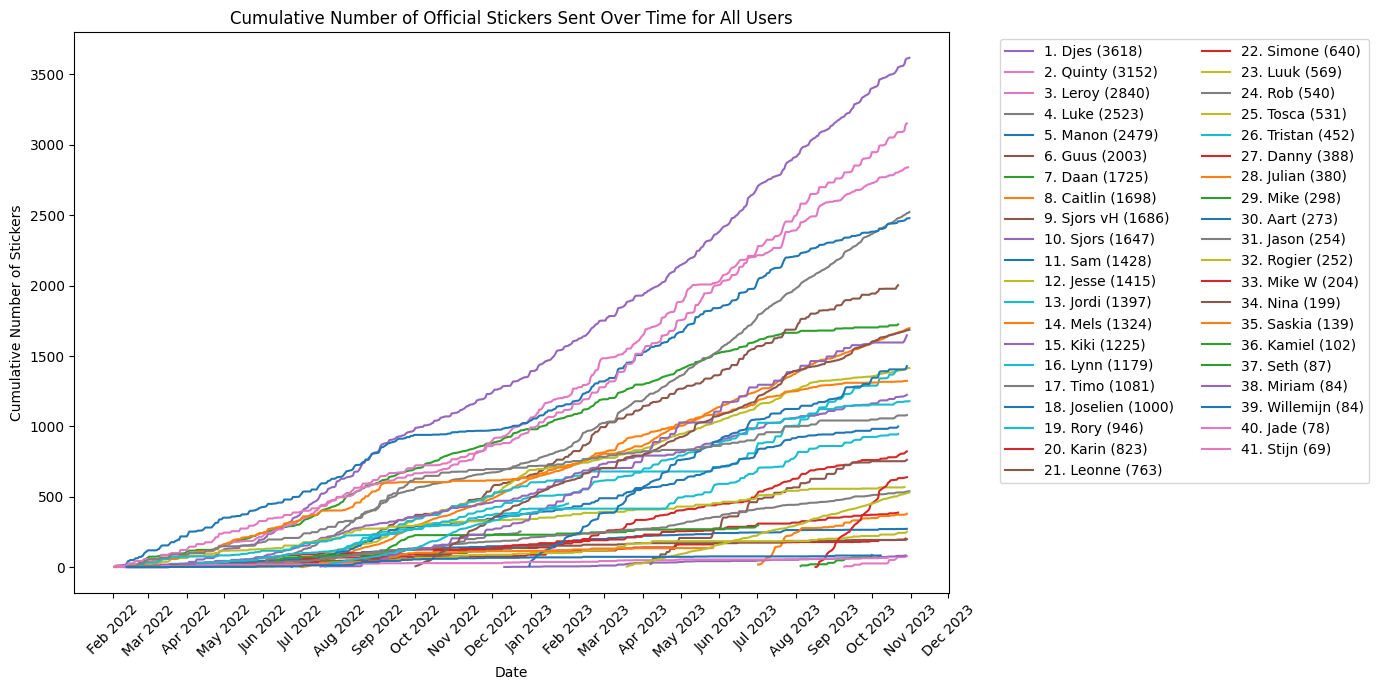

In [4]:
# Plot cumulative counts for green stickers in 2023
plot_cumulative_counts(data, 'Cumulative Number of Official Green Stickers Sent (2023)', color_filter=['green'], year_filter=2023)





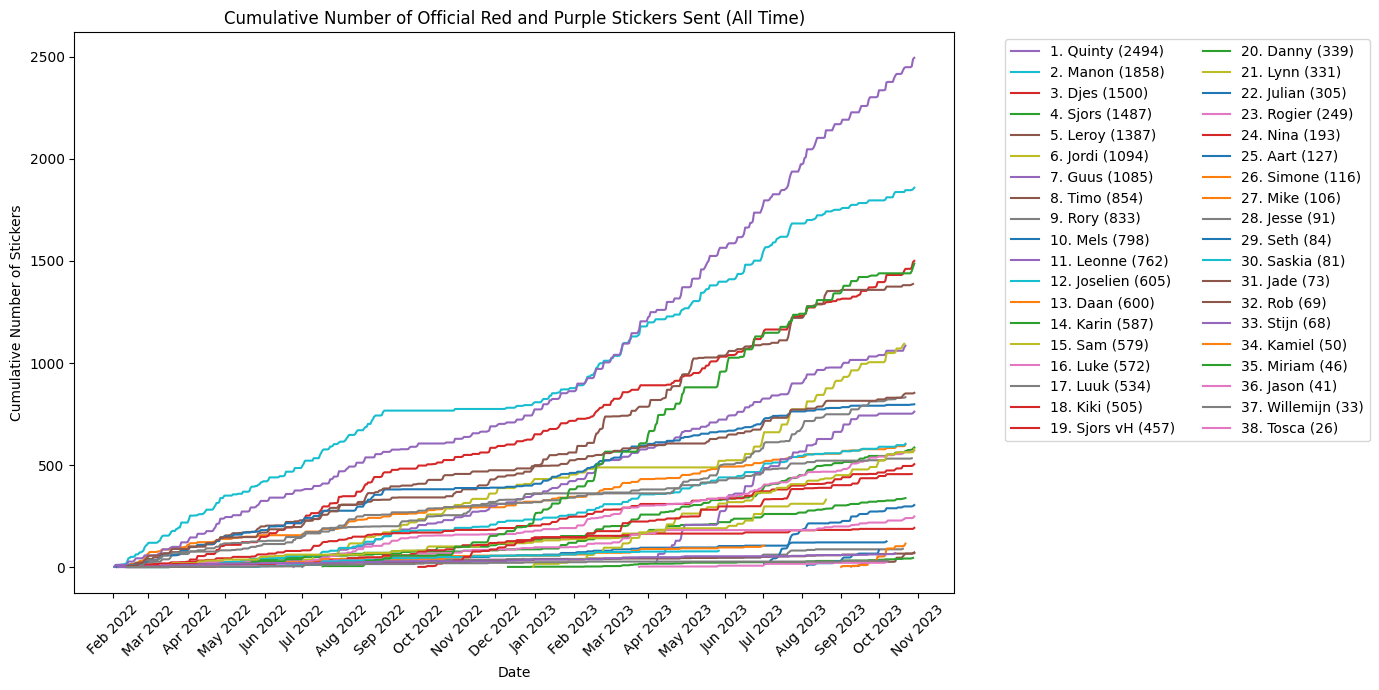

In [5]:
# Plot cumulative counts for all stickers
plot_cumulative_counts(data, 'Cumulative Number of Official Stickers Sent Over Time for All Users')



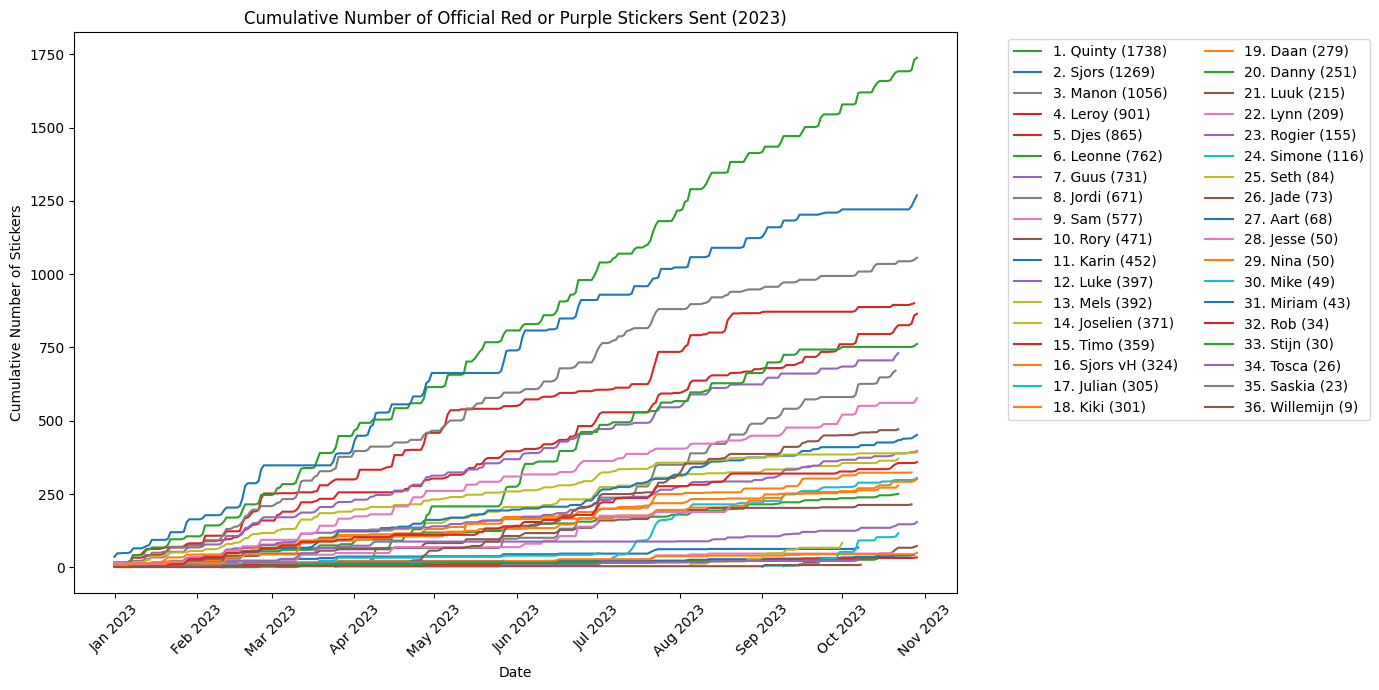

In [6]:
# Plot cumulative counts for red and purple stickers
plot_cumulative_counts(data, 'Cumulative Number of Official Red and Purple Stickers Sent Over Time', color_filter=['red', 'purple'])



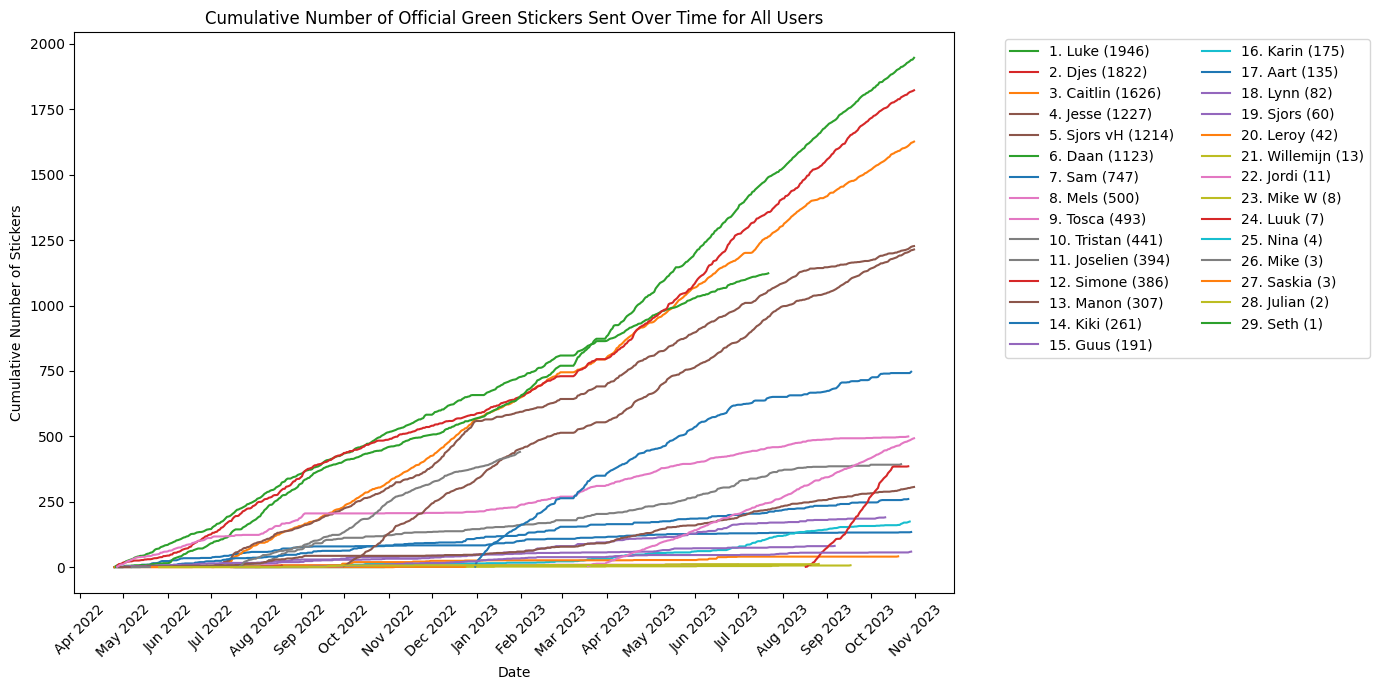

In [7]:
# Plot cumulative counts for green stickers
plot_cumulative_counts(data, 'Cumulative Number of Official Green Stickers Sent Over Time', color_filter=['green'])



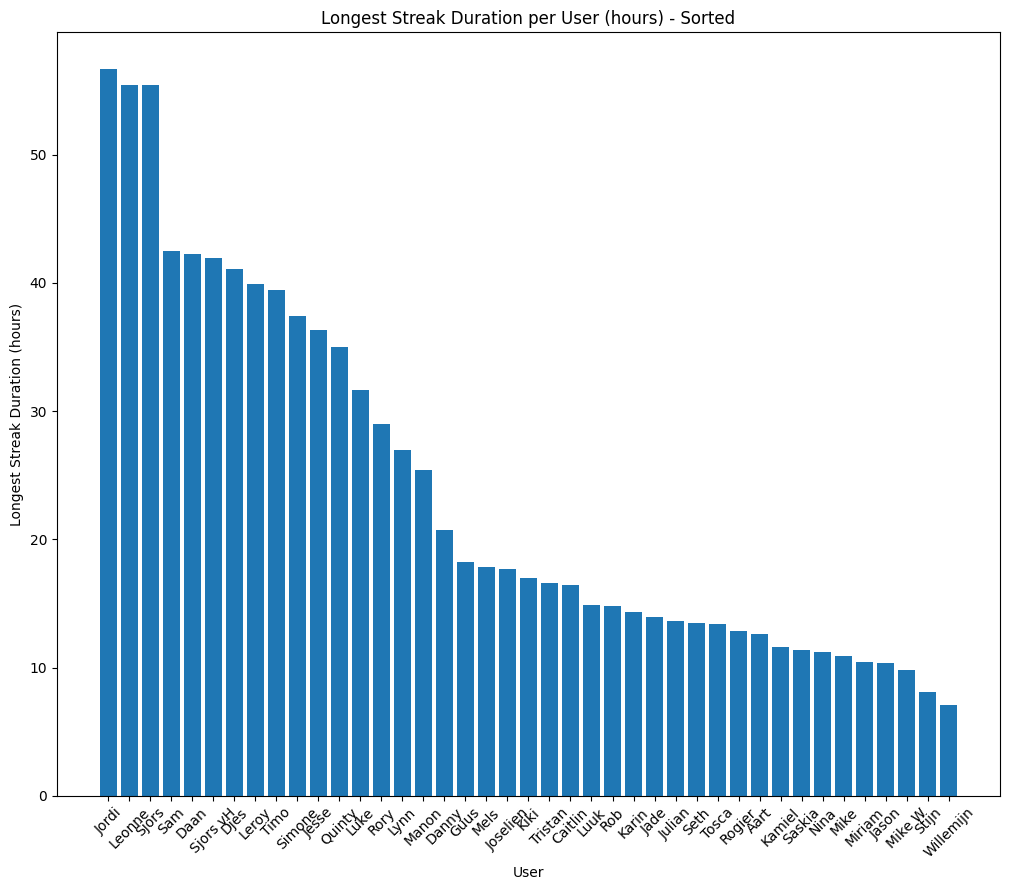

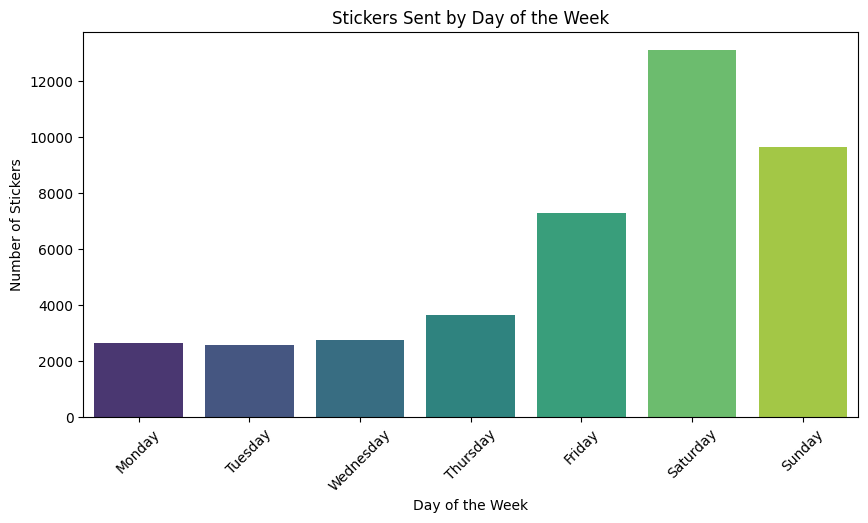

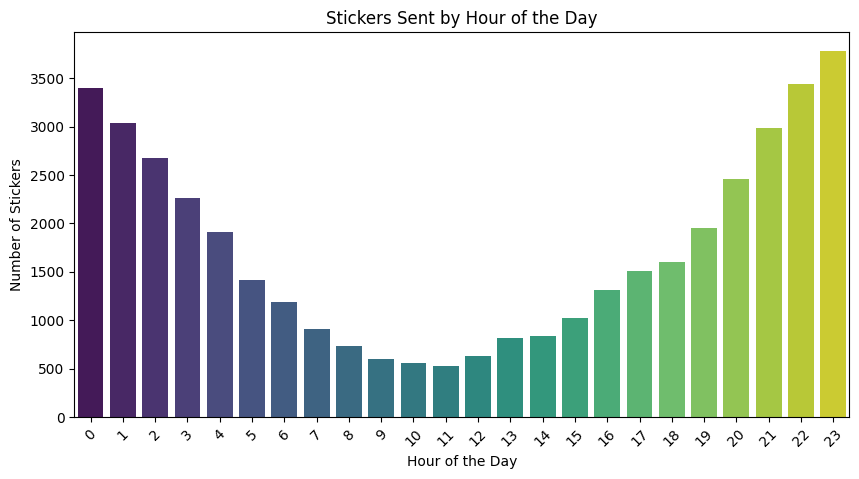

(sender
 Aart          green
 Caitlin       green
 Daan          green
 Danny           red
 Djes          green
 Guus            red
 Jade            red
 Jason        yellow
 Jesse         green
 Jordi           red
 Joselien        red
 Julian          red
 Kamiel       yellow
 Karin           red
 Kiki            red
 Leonne          red
 Leroy        yellow
 Luke          green
 Luuk            red
 Lynn         yellow
 Manon           red
 Mels            red
 Mike         yellow
 Mike W       yellow
 Miriam          red
 Nina            red
 Quinty          red
 Rob          yellow
 Rogier          red
 Rory            red
 Sam           green
 Saskia          red
 Seth            red
 Simone        green
 Sjors           red
 Sjors vH      green
 Stijn           red
 Timo            red
 Tosca         green
 Tristan       green
 Willemijn    yellow
 Name: color, dtype: object,
 'red')

In [22]:

# Calculate and display sticker discos
sticker_disco_count, last_sticker_user_count = calculate_sticker_discos(data)
# Output the results as needed, can be integrated into a visualization if desired

# Plot patterns by day and hour
plot_patterns(data, 'Stickers Sent by Day of the Week', 'Stickers Sent by Hour of the Day')

# Get and display color preferences
user_color_preferences, overall_popular_color = get_color_preferences(data)
# Output the results as needed, can be integrated into a visualization if desired
# Function to calculate the most frequently used color for each user
def get_color_preferences(df):
    # Calculate the most frequently used color for each user
    user_color_preferences = df.groupby('sender')['color'].agg(lambda x: x.value_counts().index[0])

    # Calculate the overall most popular color in the data
    overall_popular_color = df['color'].value_counts().idxmax()

    return user_color_preferences, overall_popular_color

# Get and display color preferences
user_color_preferences, overall_popular_color = get_color_preferences(data)
user_color_preferences, overall_popular_color


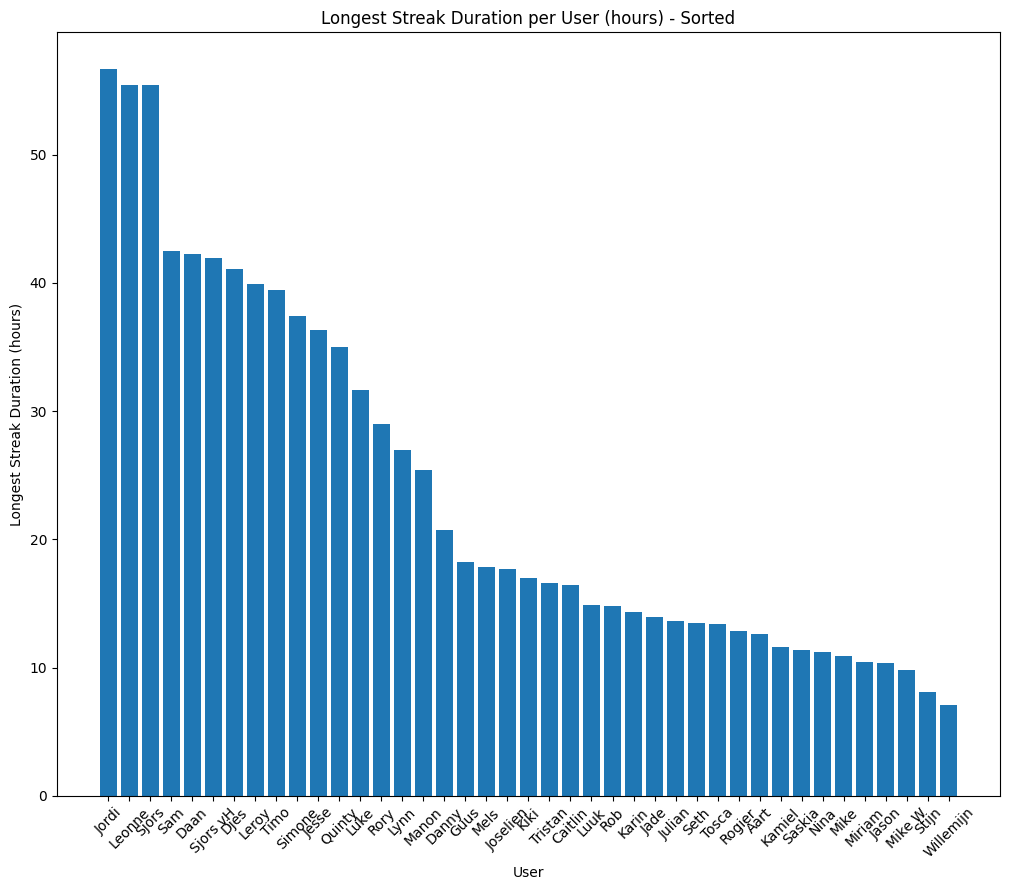

In [23]:
# Plot the longest streaks for all users
plot_longest_streaks(data, 'Longest Streak Duration per User (hours) - Sorted')

In [24]:


# Calculate color matches for each user using the DataFrame that we previously prepared
color_matches = calculate_color_matches(datay)

# Display the top 3 color matches for each user
top_color_matches = {user: matches for user, matches in color_matches.items() if matches}

# Display top 3 color matches for a few users as a sample
{user: top_color_matches[user] for user in list(top_color_matches)[:]}  # Displaying only the top 3 users


{'Manon': [('Mels', 200), ('Quinty', 198), ('Djes', 150)],
 'Luke': [('Djes', 131), ('Manon', 97), ('Mels', 86)],
 'Sam': [('Quinty', 105), ('Manon', 102), ('Djes', 83)],
 'Sjors vH': [('Quinty', 72), ('Djes', 56), ('Manon', 56)],
 'Djes': [('Luke', 162), ('Guus', 160), ('Manon', 156)],
 'Lynn': [('Quinty', 63), ('Djes', 54), ('Guus', 49)],
 'Sjors': [('Leonne', 443), ('Quinty', 109), ('Djes', 75)],
 'Quinty': [('Manon', 260), ('Djes', 200), ('Guus', 182)],
 'Nina': [('Leroy', 9), ('Sam', 8), ('Joselien', 7)],
 'Guus': [('Quinty', 121), ('Djes', 119), ('Manon', 110)],
 'Leroy': [('Quinty', 137), ('Djes', 129), ('Guus', 111)],
 'Kiki': [('Sam', 64), ('Guus', 58), ('Djes', 54)],
 'Rogier': [('Guus', 19), ('Sam', 16), ('Karin', 14)],
 'Willemijn': [('Djes', 2), ('Daan', 2), ('Luke', 1)],
 'Jordi': [('Quinty', 73), ('Djes', 57), ('Guus', 47)],
 'Mels': [('Manon', 119), ('Djes', 72), ('Quinty', 65)],
 'Rob': [('Quinty', 35), ('Leroy', 22), ('Djes', 22)],
 'Caitlin': [('Jesse', 251), ('Djes'

<ipython-input-10-c99419b777bc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datay['day_of_week'] = datay['datetime'].dt.day_name()
<ipython-input-10-c99419b777bc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datay['hour_of_day'] = datay['datetime'].dt.hour
<ipython-input-10-c99419b777bc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

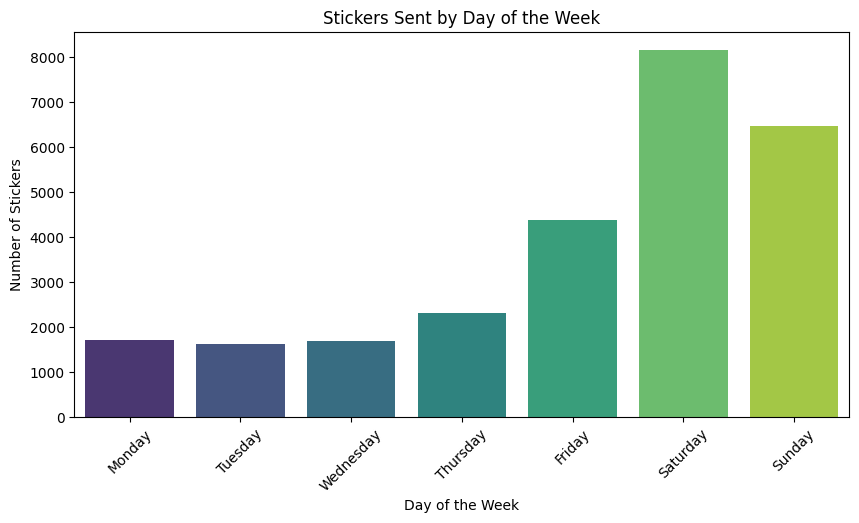

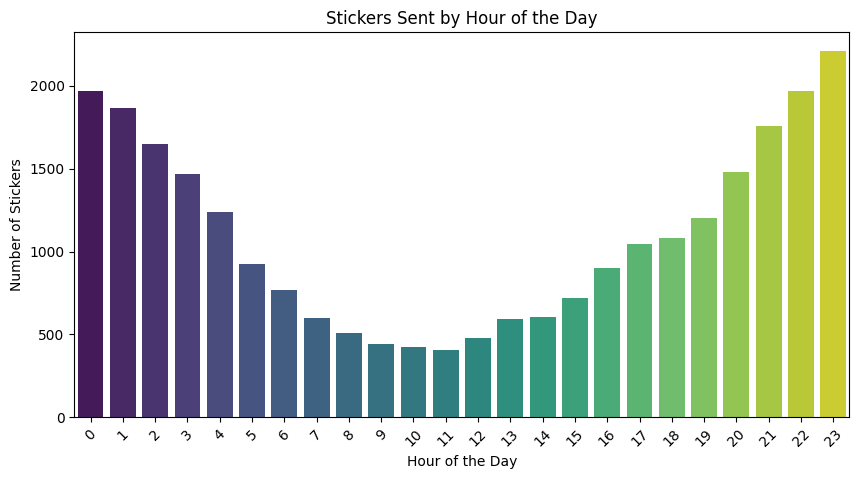

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming official_stickers_df['datetime'] is already in datetime format.

# Add columns for day of the week and hour of the day
datay['day_of_week'] = datay['datetime'].dt.day_name()
datay['hour_of_day'] = datay['datetime'].dt.hour

# Set the correct order for days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
datay['day_of_week'] = pd.Categorical(datay['day_of_week'], categories=days, ordered=True)

# Group by day of the week and hour of the day to count stickers
weekly_pattern = datay.groupby('day_of_week').size()
daily_pattern = datay.groupby('hour_of_day').size()

# Plotting the weekly pattern
plt.figure(figsize=(10, 5))
sns.barplot(x=weekly_pattern.index, y=weekly_pattern.values, palette="viridis")
plt.title('Stickers Sent by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Stickers')
plt.xticks(rotation=45)
plt.show()

# Plotting the daily pattern
plt.figure(figsize=(10, 5))
sns.barplot(x=daily_pattern.index, y=daily_pattern.values, palette="viridis")
plt.title('Stickers Sent by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Stickers')
plt.xticks(rotation=45)
plt.show()


In [11]:
# Calculate the most frequently used color for each user
user_color_preferences = datay.groupby('sender')['color'].agg(lambda x: x.value_counts().index[0])

# Calculate the overall most popular color in the group chat
overall_popular_color = datay['color'].value_counts().idxmax()

# Display the color preferences for the first few users
user_color_preferences, overall_popular_color


(sender
 Aart            red
 Caitlin       green
 Daan          green
 Danny           red
 Djes          green
 Guus            red
 Jade            red
 Jesse         green
 Jordi           red
 Joselien        red
 Julian          red
 Karin           red
 Kiki            red
 Leonne          red
 Leroy        yellow
 Luke          green
 Luuk            red
 Lynn         yellow
 Manon           red
 Mels            red
 Mike            red
 Mike W       yellow
 Miriam          red
 Nina            red
 Quinty          red
 Rob          yellow
 Rogier          red
 Rory            red
 Sam           green
 Saskia          red
 Seth            red
 Simone        green
 Sjors           red
 Sjors vH      green
 Stijn           red
 Timo            red
 Tosca         green
 Tristan       green
 Willemijn    purple
 Name: color, dtype: object,
 'red')

In [12]:


# Count all 'sticker discos' and the last user
sticker_disco_count, last_sticker_user_count = count_sticker_discos_and_last_user(datay)

# Output the number of 'sticker discos' and the sorted list of users who sent the last sticker most often
sticker_disco_count, last_sticker_user_count


(183,
 [('Leroy', 23),
  ('Guus', 14),
  ('Sam', 12),
  ('Luke', 12),
  ('Quinty', 9),
  ('Lynn', 9),
  ('Caitlin', 8),
  ('Karin', 8),
  ('Sjors vH', 8),
  ('Miriam', 8),
  ('Kiki', 7),
  ('Djes', 6),
  ('Timo', 5),
  ('Daan', 5),
  ('Rory', 5),
  ('Simone', 5),
  ('Sjors', 4),
  ('Mels', 4),
  ('Julian', 4),
  ('Jesse', 3),
  ('Rob', 3),
  ('Manon', 3),
  ('Tosca', 3),
  ('Danny', 2),
  ('Mike W', 2),
  ('Aart', 2),
  ('Nina', 1),
  ('Jordi', 1),
  ('Saskia', 1),
  ('Rogier', 1),
  ('Joselien', 1),
  ('Luuk', 1),
  ('Willemijn', 1),
  ('Seth', 1),
  ('Jade', 1)])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-

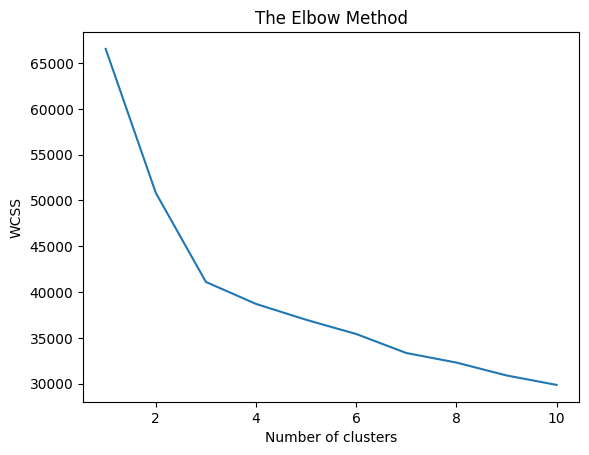

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the 'sender' and 'color' columns
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(data[['sender', 'color']])


# Let's calculate wcss for the encoded features.
wcss = calculate_wcss(encoded_features)


plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()




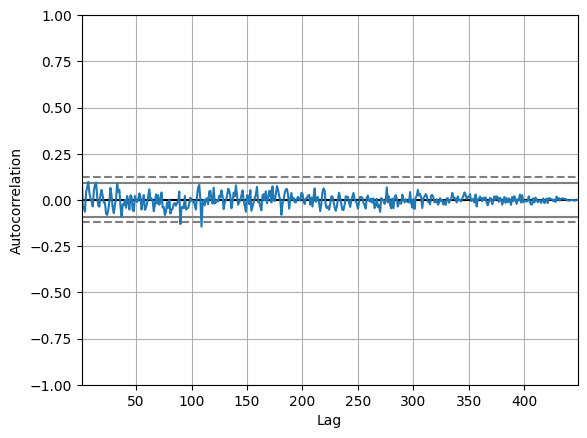

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

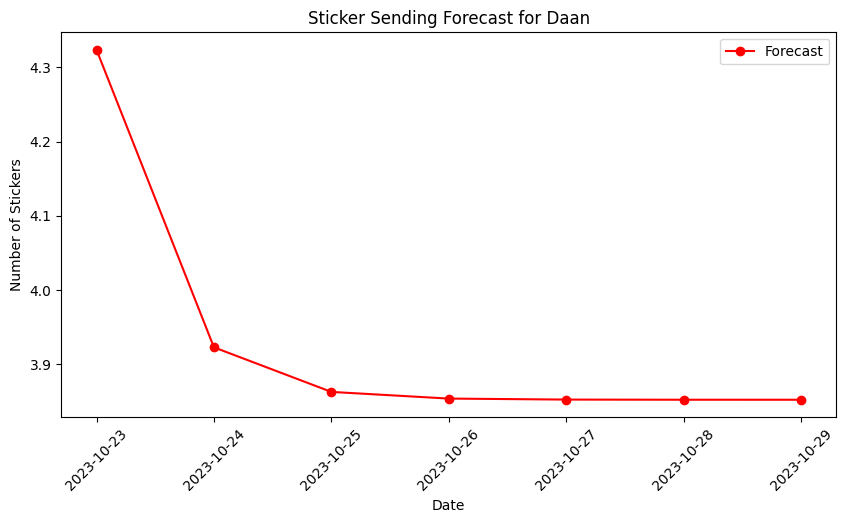

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import numpy as np

# Selecting a random user for predictive modeling
random_user = np.random.choice(data['sender'].unique())
random_user_data = data[data['sender'] == random_user]

# Aggregating sticker data by date for the random user
random_user_data = random_user_data.groupby(random_user_data['datetime'].dt.date).size()

# Plot the autocorrelation to help choose ARIMA parameters
autocorrelation_plot(random_user_data)
plt.show()

# The ARIMA parameters (p,d,q) need to be chosen based on the autocorrelation plot
# For simplicity, we'll use (1,1,1) as an example
random_model = ARIMA(random_user_data, order=(1,1,1))
random_model_fit = random_model.fit()

# Forecast the next 7 days for the random user
random_forecast = random_model_fit.forecast(steps=7)

random_user, random_forecast
# Let's extract the dates for the forecasted period to display on the x-axis
forecast_dates = pd.date_range(start=random_user_data.index[-1] + timedelta(days=1), periods=7)

# Plot the forecast with the dates on the x-axis
plt.figure(figsize=(10, 5))
plt.plot(forecast_dates, random_forecast, marker='o', color='red', label='Forecast')
plt.title(f'Sticker Sending Forecast for {random_user}')
plt.xlabel('Date')
plt.ylabel('Number of Stickers')
plt.xticks(rotation=45)
plt.legend()
plt.show()


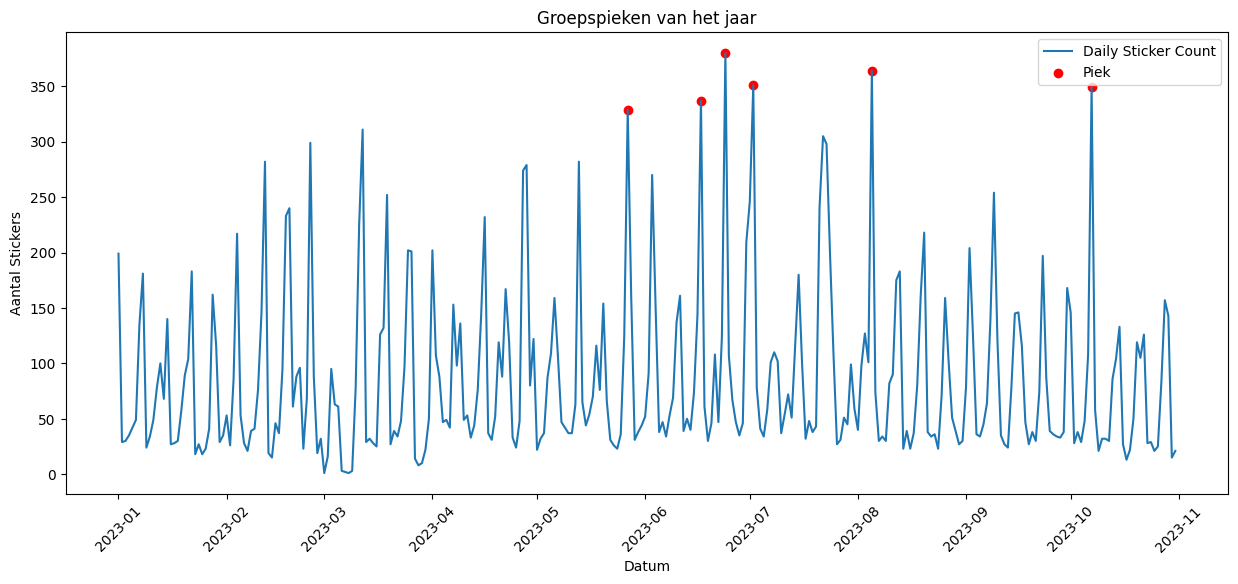

datetime
2023-05-27    329
2023-06-17    337
2023-06-24    380
2023-07-02    351
2023-08-05    364
2023-10-07    349
dtype: int64

In [28]:
from scipy import stats

# Aggregating sticker data by date for the entire dataset
daily_stickers = datay.groupby(data['datetime'].dt.date).size()

# Calculate Z-scores for the daily sticker count
z_scores = stats.zscore(daily_stickers)

# Identify anomalies (here we're using a threshold of 3 standard deviations)
anomalies = daily_stickers[(np.abs(z_scores) > 3)]

# Plot the daily sticker count with anomalies highlighted
plt.figure(figsize=(15, 6))
plt.plot(daily_stickers.index, daily_stickers.values, label='Daily Sticker Count')
plt.scatter(anomalies.index, anomalies.values, color='red', label='Piek')
plt.title('Groepspieken van het jaar')
plt.xlabel('Datum')
plt.ylabel('Aantal Stickers')
plt.xticks(rotation=45)
plt.legend()
plt.show()

anomalies


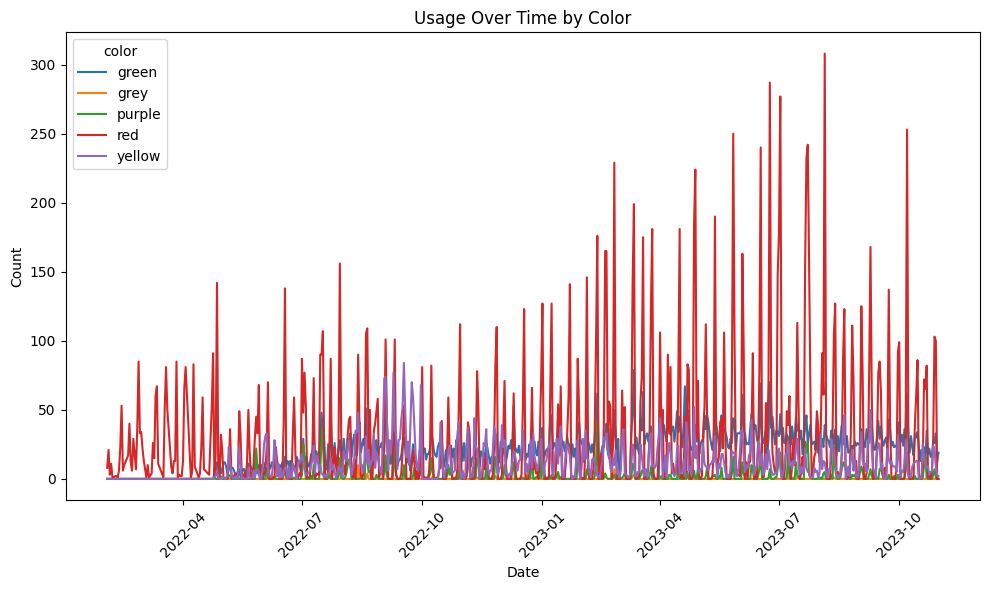

In [31]:
# Aggregate data by date and color
usage_over_time = data.groupby([data['datetime'].dt.date, 'color']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Set the size of the plot
usage_over_time.plot(kind='line', ax=ax)  # This will create one line per color automatically

# Enhancing the plot
ax.set_title('Usage Over Time by Color')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

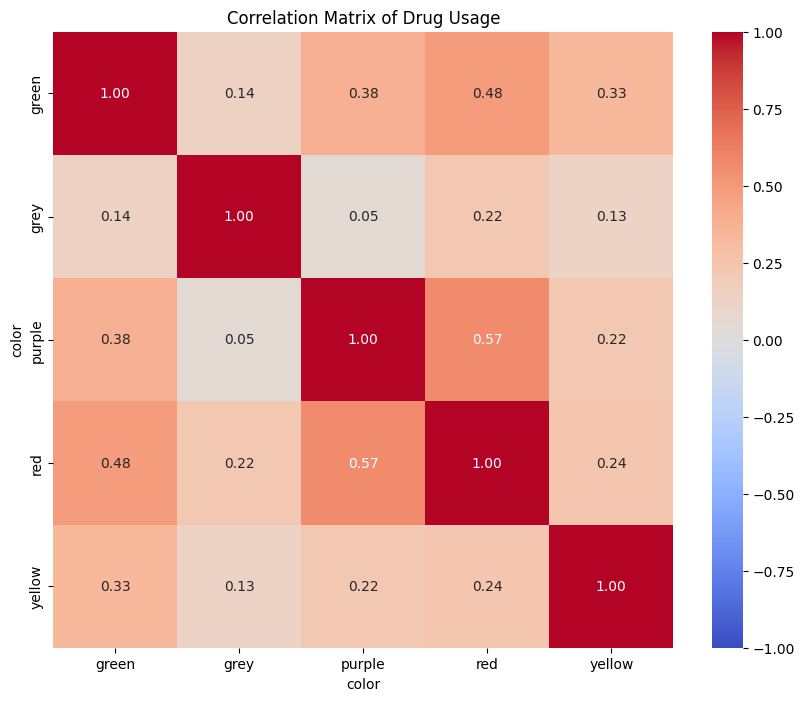

In [38]:
import seaborn as sns
# Compute the correlation matrix for drug usage
correlation_matrix = usage_over_time.corr()
# Visualize the correlation matrix again
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Drug Usage')
plt.show()




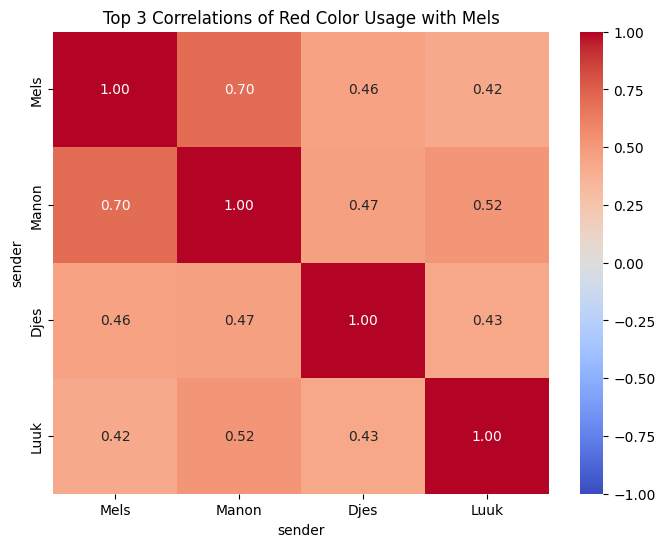

In [37]:
# Aggregate data by date and sender for 'red' color stickers only

red_usage_by_user = data[data['color'] == 'red'].groupby(

    [data['datetime'].dt.date, 'sender']).size().unstack(fill_value=0)



# Compute the correlation matrix for 'red' color usage between different users

correlation_matrix_red = red_usage_by_user.corr()

# Identify the top 3 users with the highest correlation in red color usage with 'Mels'
mels_correlation = correlation_matrix_red['Mels'].drop('Mels')  # Drop self-correlation
top3_correlated_users = mels_correlation.abs().sort_values(ascending=False).head(3).index.tolist()

# Select only 'Mels' and the top 3 correlated users
top_correlations_red = correlation_matrix_red.loc[['Mels'] + top3_correlated_users, ['Mels'] + top3_correlated_users]

# Visualize the correlation matrix for 'red' color for 'Mels' and the top 3 correlated users
plt.figure(figsize=(8, 6))
sns.heatmap(top_correlations_red, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Top 3 Correlations of Red Color Usage with Mels')
plt.show()

In [40]:


# Function to calculate average time between uses for each drug
def average_time_between_uses(data):
    time_differences = []

    # Group by user and color
    grouped_data = data.groupby(['sender', 'color'])

    for _, group in grouped_data:
        # Sort by datetime to get consecutive uses
        sorted_group = group.sort_values(by='datetime')
        # Calculate time differences between consecutive uses
        time_diffs = sorted_group['datetime'].diff().dropna()
        time_differences.extend(time_diffs)

    # Calculate the average time difference
    average_time = pd.Series(time_differences).mean()
    return average_time

# Calculate the average time between uses for each clock
average_times = {color: average_time_between_uses(data[data['color'] == color]) for color in ['red','purple','green', 'yellow']}

average_times


{'red': Timedelta('0 days 20:17:33.554737810'),
 'purple': Timedelta('9 days 07:57:42.646120377'),
 'green': Timedelta('0 days 19:37:14.947555892'),
 'yellow': Timedelta('1 days 13:41:52.736710963')}

In [41]:
# Function to find co-usage patterns within a day for a user
def find_co_usage_patterns(data, time_window='1H'):
    co_usage_counts = {}

    # Group by user and date
    grouped_data = data.groupby(['sender', data['datetime'].dt.date])

    for _, group in grouped_data:
        # Resample the data within each day according to the time window
        resampled_group = group.groupby(pd.Grouper(key='datetime', freq=time_window))

        for _, window_group in resampled_group:
            clocks_used = window_group['color'].unique()
            if len(clocks_used) > 1:
                # If more than one clock is used in the time window, count the co-usage
                co_usage = tuple(sorted(clocks_used))
                co_usage_counts[co_usage] = co_usage_counts.get(co_usage, 0) + 1

    return co_usage_counts

# Find co-usage patterns with a 1-hour time window
co_usage_patterns = find_co_usage_patterns(data, time_window='1H')

# Sort and display the most common co-usage patterns
sorted_co_usage_patterns = sorted(co_usage_patterns.items(), key=lambda item: item[1], reverse=True)
sorted_co_usage_patterns[:10]  # Display the top 10 most common co-usage patterns


[(('green', 'red'), 1227),
 (('red', 'yellow'), 631),
 (('purple', 'red'), 323),
 (('green', 'yellow'), 237),
 (('green', 'purple'), 54),
 (('green', 'red', 'yellow'), 54),
 (('purple', 'yellow'), 42),
 (('grey', 'red'), 22),
 (('green', 'purple', 'red'), 19),
 (('purple', 'red', 'yellow'), 17)]

In [42]:
# Function to analyze user-specific patterns
def analyze_user_patterns(user_data):
    user_patterns = {}

    # Calculate the most frequently used clock
    clock = user_data['color'].mode().iloc[0]
    user_patterns['Favorite clock'] = clock

    # Calculate the most common day of the week for clock use
    favorite_day = user_data['datetime'].dt.day_name().mode().iloc[0]
    user_patterns['Favorite Day'] = favorite_day

    # Calculate the most common hour of the day for clock use
    favorite_hour = user_data['datetime'].dt.hour.mode().iloc[0]
    user_patterns['Favorite Hour'] = f"{favorite_hour}:00-{favorite_hour+1}:00"

    return user_patterns

# Analyze patterns for a few random users
random_users = np.random.choice(data['sender'].unique(), 30, replace=False)
user_specific_patterns = {user: analyze_user_patterns(data[data['sender'] == user]) for user in random_users}

user_specific_patterns


{'Tosca': {'Favorite clock': 'green',
  'Favorite Day': 'Sunday',
  'Favorite Hour': '21:00-22:00'},
 'Lynn': {'Favorite clock': 'yellow',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '22:00-23:00'},
 'Manon': {'Favorite clock': 'red',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '0:00-1:00'},
 'Rogier': {'Favorite clock': 'red',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '1:00-2:00'},
 'Stijn': {'Favorite clock': 'red',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '1:00-2:00'},
 'Jesse': {'Favorite clock': 'green',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '23:00-24:00'},
 'Danny': {'Favorite clock': 'red',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '23:00-24:00'},
 'Jordi': {'Favorite clock': 'red',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '20:00-21:00'},
 'Sam': {'Favorite clock': 'green',
  'Favorite Day': 'Sunday',
  'Favorite Hour': '0:00-1:00'},
 'Luke': {'Favorite clock': 'green',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '23:00-24:

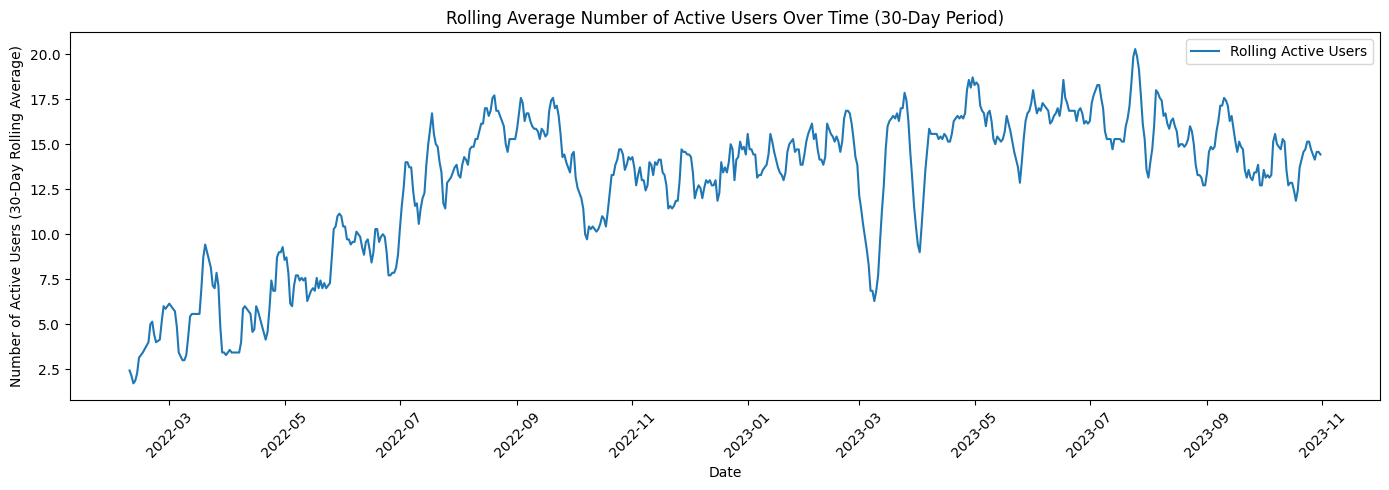

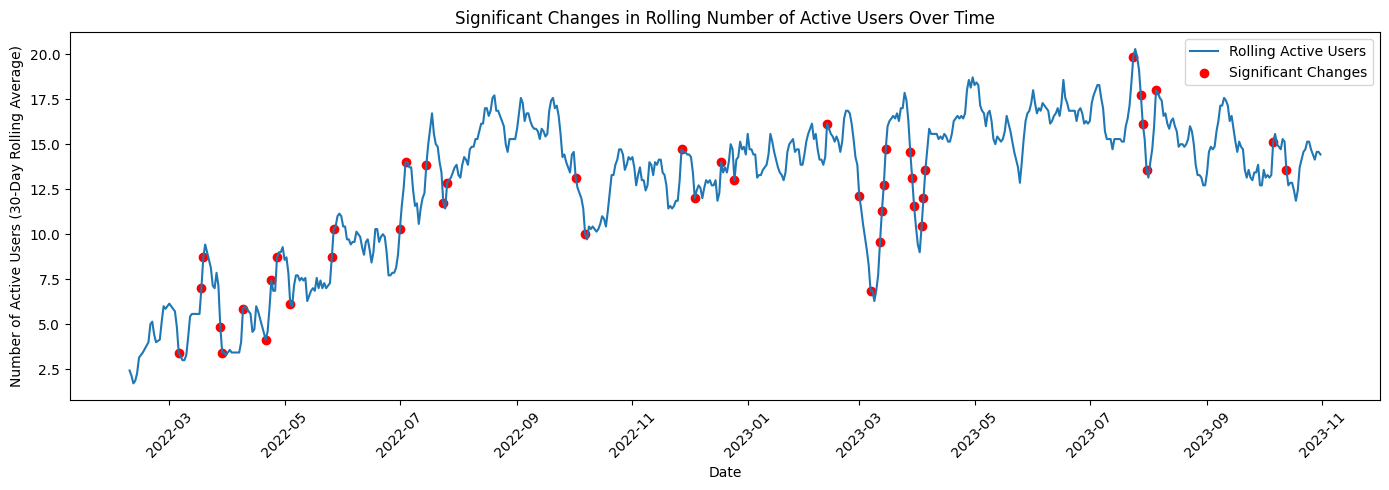

In [56]:
# Define active users based on a rolling period of 30 days
rolling_active_users = data.groupby(data['datetime'].dt.to_period("D"))['sender'].nunique().rolling(window=7).mean().dropna()

# Convert to a time series with dates as the index
rolling_active_users.index = rolling_active_users.index.to_timestamp()
ts_rolling_active_users = pd.Series(rolling_active_users, index=rolling_active_users.index)

# Plot the rolling number of active users over time
plt.figure(figsize=(14, 5))
plt.title('Rolling Average Number of Active Users Over Time (30-Day Period)')
plt.plot(ts_rolling_active_users, label='Rolling Active Users')
plt.xlabel('Date')
plt.ylabel('Number of Active Users (30-Day Rolling Average)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Re-evaluate significant changes with the new definition
mean_rolling_change = ts_rolling_active_users.diff().mean()
std_rolling_change = ts_rolling_active_users.diff().std()
significant_rolling_changes = ts_rolling_active_users.diff().abs()/2 > (mean_rolling_change + std_rolling_change)

# Plotting the significant changes with the new definition
plt.figure(figsize=(14, 5))
plt.title('Significant Changes in Rolling Number of Active Users Over Time')
plt.plot(ts_rolling_active_users, label='Rolling Active Users')
plt.scatter(ts_rolling_active_users[significant_rolling_changes].index, ts_rolling_active_users[significant_rolling_changes], color='red', label='Significant Changes')
plt.xlabel('Date')
plt.ylabel('Number of Active Users (30-Day Rolling Average)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


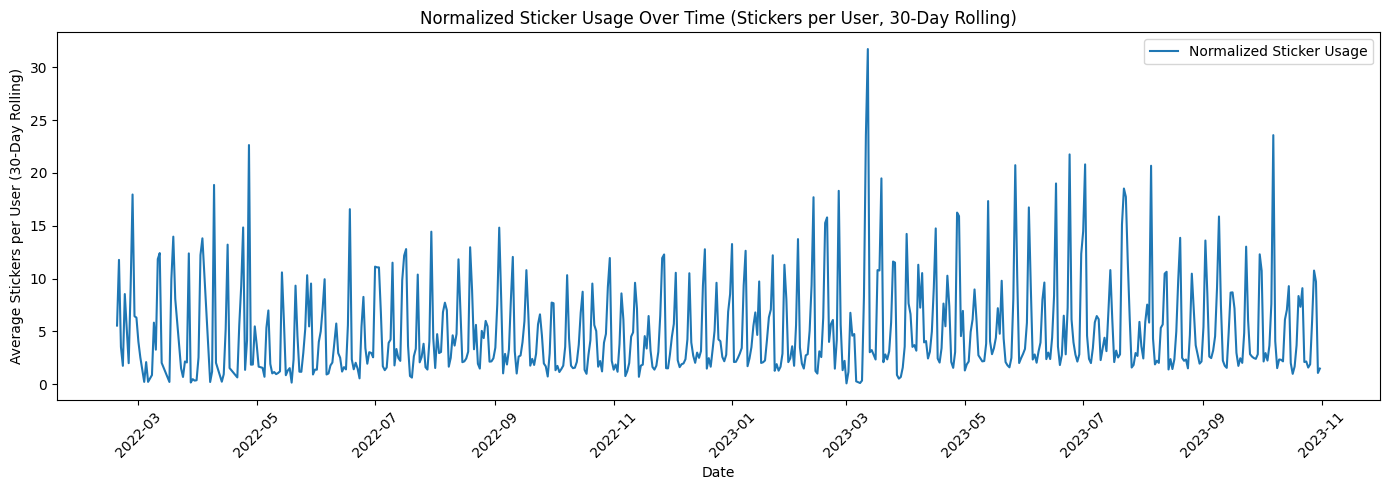

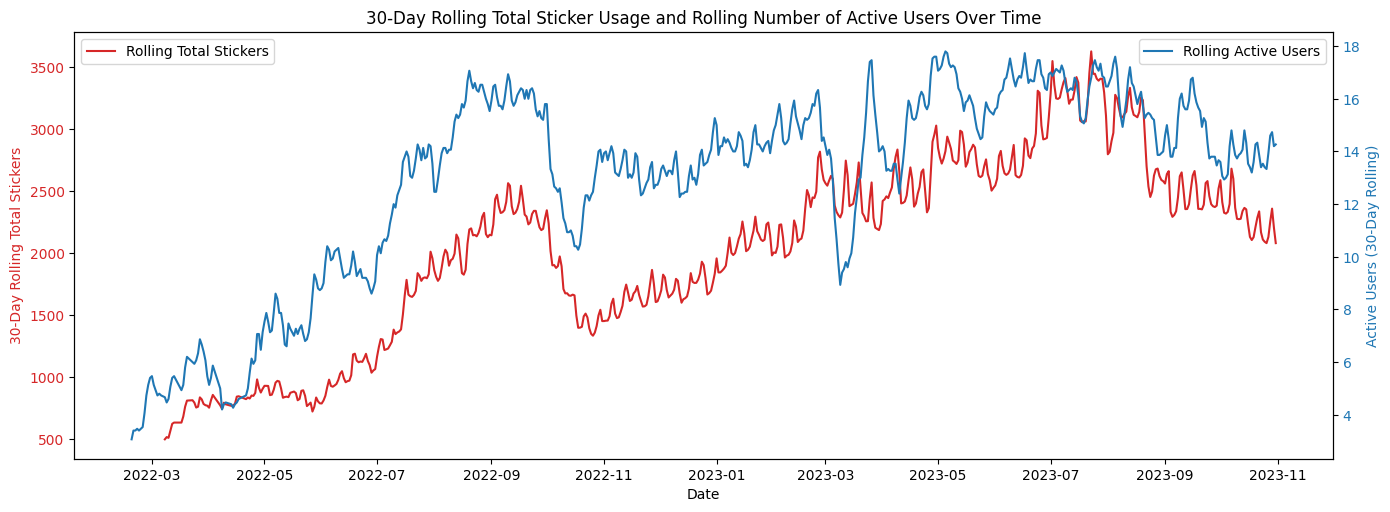

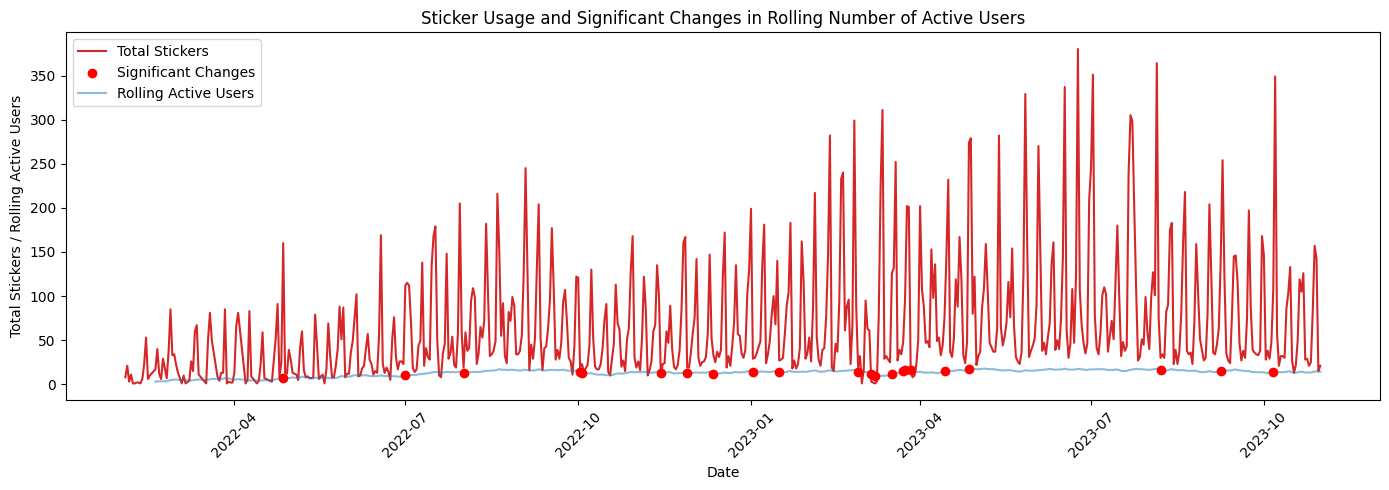

In [55]:
# Normalize sticker usage by the rolling number of active users to get the average number of stickers per user per day
normalized_rolling_sticker_usage = ts_sticker_usage / ts_rolling_active_users

# Plot normalized sticker usage over time with the new definition of active users
plt.figure(figsize=(14, 5))
plt.title('Normalized Sticker Usage Over Time (Stickers per User, 30-Day Rolling)')
plt.plot(normalized_rolling_sticker_usage, label='Normalized Sticker Usage')
plt.xlabel('Date')
plt.ylabel('Average Stickers per User (30-Day Rolling)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Calculate the total sticker usage on a 30-day rolling basis
rolling_total_sticker_usage = ts_sticker_usage.rolling(window=30).sum()
# Overlay rolling total sticker usage and rolling active users on the same graph
fig, ax1 = plt.subplots(figsize=(14, 5))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('30-Day Rolling Total Stickers', color=color)
ax1.plot(rolling_total_sticker_usage, color=color, label='Rolling Total Stickers')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Active Users (30-Day Rolling)', color=color)  # we already handled the x-label with ax1
ax2.plot(ts_rolling_active_users, color=color, label='Rolling Active Users')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('30-Day Rolling Total Sticker Usage and Rolling Number of Active Users Over Time')
plt.xticks(rotation=45)
plt.show()


# Re-plot significant changes in the rolling number of active users and sticker usage
plt.figure(figsize=(14, 5))
plt.title('Sticker Usage and Significant Changes in Rolling Number of Active Users')
plt.plot(ts_sticker_usage, label='Total Stickers', color='tab:red')
plt.scatter(ts_rolling_active_users[significant_rolling_changes].index, ts_rolling_active_users[significant_rolling_changes], color='red', label='Significant Changes', zorder=5)
plt.plot(ts_rolling_active_users, label='Rolling Active Users', color='tab:blue', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Total Stickers / Rolling Active Users')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


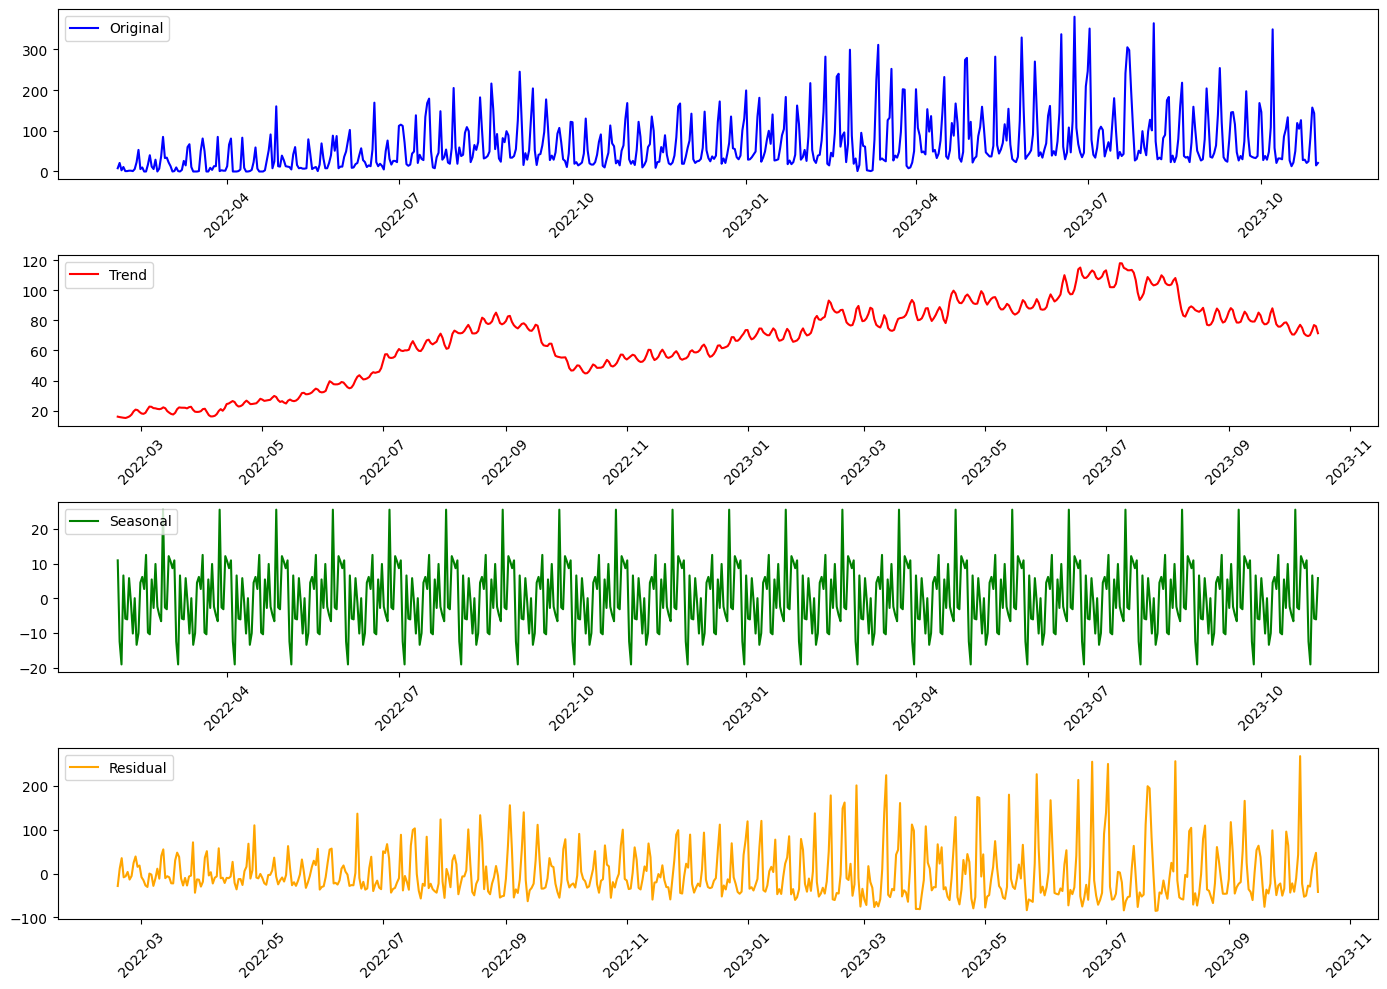

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

# First, we need to make sure our time series is complete with no missing dates
# We will fill missing dates with zeros for this decomposition
ts_sticker_usage_complete = ts_sticker_usage.asfreq('D', fill_value=0)

# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(ts_sticker_usage_complete, model='additive', period=30)

# Extract the estimated trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data and the decomposed components
plt.figure(figsize=(14, 10))

# Original data
plt.subplot(411)
plt.plot(ts_sticker_usage_complete, label='Original', color='blue')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Trend
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Seasonal
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Residual
plt.subplot(414)
plt.plot(residual, label='Residual', color='orange')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
